# Hex Game - GTM Analysis & Experiments

This notebook performs a comprehensive analysis of the Graph Tsetlin Machine (GTM) on the Hex game.
It implements:
1.  **Robust Data Generation**: Reproducible, seeded games (saved to CSV).
2.  **End-Game Analysis**: Evaluation at Final, End-2, and End-5 moves.
3.  **Parameter Search**: Experiments for Model Capacity (Clauses) and Message Passing (Depth).
4.  **Scaling**: Flexible configuration for 3x3, 11x11, etc.

---

In [132]:
import os
import pickle
import subprocess
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import gc

# Try importing GTM
try:
    from GraphTsetlinMachine.graphs import Graphs
    from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
    HAS_GTM = True
    print("✓ GraphTsetlinMachine detected.")
except ImportError:
    print("WARNING: GraphTsetlinMachine not installed. Training will fail.")
    HAS_GTM = False

# Set Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120

✓ GraphTsetlinMachine detected.


In [133]:
# ==========================================
#            GLOBAL CONFIGURATION
# ==========================================

BOARD_DIM = 13        # 7x7 board
N_GAMES = 10000      # CRITICAL: Need MORE data for 7x7!
SEED = 20

# OPTIMIZED HYPERPARAMETERS FOR 7x7
# These are specifically tuned for the connectivity problem
if BOARD_DIM == 7:
    # START CONSERVATIVE - we can scale up if needed
    CLAUSES = 2000        # Moderate capacity
    T = 50              # Not too permissive (prevents collapse)
    S = 0.8              # Balanced feature selection
    DEPTH = 3            # Moderate message passing
    EPOCHS = 100          # More epochs to allow convergence
    HYPERVECTOR_SIZE = 256
    MESSAGE_SIZE = 256
    GRID_MULT = 3


elif BOARD_DIM == 3:
    CLAUSES = 400
    T = 400
    S = 2.5
    DEPTH = 3
    EPOCHS = 100
    HYPERVECTOR_SIZE = 256
    MESSAGE_SIZE = 256
    GRID_MULT = 1

elif BOARD_DIM == 11:
    CLAUSES = 2000
    T = 60
    S = 0.9
    DEPTH = 3
    EPOCHS = 40
    HYPERVECTOR_SIZE = 1024
    MESSAGE_SIZE = 1024
    GRID_MULT = 4
    USE_ROTATION_AUGMENTATION = True

else:
    # Fallback
    CLAUSES = 200
    T = 400
    S = 2.5
    DEPTH = 3
    EPOCHS = 25
    HYPERVECTOR_SIZE = 256
    MESSAGE_SIZE = 256
    GRID_MULT = 1

print(f"\n{'='*60}")
print(f"  CONFIGURATION: {BOARD_DIM}x{BOARD_DIM} Hex Board")
print(f"{'='*60}")
print(f"  Games:         {N_GAMES:,}")
print(f"  Seed:          {SEED}")
print(f"  Clauses:       {CLAUSES:,}")
print(f"  T:             {T}")
print(f"  S:             {S}")
print(f"  Depth:         {DEPTH}")
print(f"  Epochs:        {EPOCHS}")
print(f"  Hypervec Size: {HYPERVECTOR_SIZE}")
print(f"  Message Size:  {MESSAGE_SIZE}")
print(f"{'='*60}\n")

# Paths
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)
CSV_PATH = os.path.join(RUNS_DIR, f"hex_moves_dim{BOARD_DIM}_n{N_GAMES}.csv")


  CONFIGURATION: 13x13 Hex Board
  Games:         10,000
  Seed:          20
  Clauses:       200
  T:             400
  S:             2.5
  Depth:         3
  Epochs:        25
  Hypervec Size: 256
  Message Size:  256



## 1. Data Generation & Processing
We use the C engine to generate games and save them to CSV. This ensures we have a permanent, reproducible dataset.

In [134]:
def generate_data():
    """Generates game data using ./scripts/run_hex.sh"""
    if os.path.exists(CSV_PATH):
        print(f"Found existing data: {CSV_PATH}")
        # You can uncomment the next line to force regeneration
        # os.remove(CSV_PATH)
        return
        
    print(f"Generating {N_GAMES} games for {BOARD_DIM}x{BOARD_DIM} (Seed {SEED})...")
    cmd = [
        "./scripts/run_hex.sh",
        "--games", str(N_GAMES),
        "--seed", str(SEED),
        "--dump-moves", CSV_PATH
    ]
    
    env = os.environ.copy()
    env["BOARD_DIM"] = str(BOARD_DIM)
    
    start = time.time()
    subprocess.run(cmd, env=env, check=True)
    print(f"Done in {time.time() - start:.2f}s")

def load_and_process_data(offset=0):
    """
    Loads CSV and reconstructs board states.
    offset: Number of moves before the end to capture (0=End, 2=End-2, etc.)
    """
    print(f"Processing data with Offset={offset}...")
    df = pd.read_csv(CSV_PATH)
    
    n_nodes = BOARD_DIM * BOARD_DIM
    x_feat = []
    o_feat = []
    labels = []
    
    # Group by game
    for game_id, group in tqdm(df.groupby("game_id"), desc="Replaying Games"):
        # Skip if game is too short
        if len(group) <= offset:
            continue
            
        # Slice moves
        moves = group.iloc[:-offset] if offset > 0 else group
        winner = group["winner"].iloc[0]
        
        p0 = np.zeros(n_nodes, dtype=np.int8)
        p1 = np.zeros(n_nodes, dtype=np.int8)
        
        for _, row in moves.iterrows():
            r, c, p = int(row['row']), int(row['col']), int(row['player'])
            idx = r * BOARD_DIM + c
            if 0 <= idx < n_nodes:
                if p == 0: p0[idx] = 1
                else: p1[idx] = 1
                    
        x_feat.append(p0)
        o_feat.append(p1)
        labels.append(winner)
        
    return np.array(x_feat), np.array(o_feat), np.array(labels)

def prepare_graphs(x, o, init_with=None):
    """Converts Feature Maps -> GTM Graphs using explicit E/X/O symbols"""
    if not HAS_GTM: return None

    n_samples = len(x)
    n_nodes = BOARD_DIM * BOARD_DIM

    # Convert to string representation
    board_strings = []
    for i in range(n_samples):
        board_str = []
        for node in range(n_nodes):
            if x[i][node] == 1:
                board_str.append("X")
            elif o[i][node] == 1:
                board_str.append("O")
            else:
                board_str.append("E")
        board_strings.append(board_str)

    graphs = Graphs(
        n_samples,
        symbols=["E", "X", "O"],  # Explicit order
        hypervector_size=HYPERVECTOR_SIZE,
        hypervector_bits=2,
        init_with=init_with
    )

    # Hex Edges - 6-neighbor topology
    offsets = [(0, 1), (0, -1), (-1, 1), (1, -1), (-1, 0), (1, 0)]
    adjacency = {}
    for r in range(BOARD_DIM):
        for c in range(BOARD_DIM):
            u = r * BOARD_DIM + c
            adjacency[u] = []
            for dr, dc in offsets:
                nr, nc = r + dr, c + dc
                if 0 <= nr < BOARD_DIM and 0 <= nc < BOARD_DIM:
                    adjacency[u].append(nr * BOARD_DIM + nc)

    # Node Config
    for i in range(n_samples):
        graphs.set_number_of_graph_nodes(i, n_nodes)
    graphs.prepare_node_configuration()

    # Edge Config
    for i in range(n_samples):
        for u in range(n_nodes):
            graphs.add_graph_node(i, u, len(adjacency[u]))
    graphs.prepare_edge_configuration()

    # Add Edges (bidirectional)
    for i in range(n_samples):
        for u in range(n_nodes):
            for v in adjacency[u]:
                graphs.add_graph_node_edge(i, u, v, 0)

    # Add Properties using string symbols
    for i in range(n_samples):
        for u in range(n_nodes):
            graphs.add_graph_node_property(i, u, board_strings[i][u])

    graphs.encode()
    return graphs

# ============================================================
#         ROTATION AUGMENTATION (Optional Enhancement)
# ============================================================

USE_ROTATION_AUGMENTATION = False  # Set to True to enable

def rotate_board_90(board_1d, board_dim):
    """Rotate board 90 degrees clockwise"""
    board_2d = board_1d.reshape(board_dim, board_dim)
    rotated = np.rot90(board_2d, k=-1)  # k=-1 = clockwise
    return rotated.flatten()

def augment_with_rotation(X_raw, O_raw, Y):
    """
    Double dataset by adding 90° rotated versions.
    When rotated, TOP-BOTTOM becomes LEFT-RIGHT, so labels swap.
    """
    print("\n" + "="*60)
    print("  APPLYING ROTATION AUGMENTATION")
    print("="*60)

    X_augmented = []
    O_augmented = []
    Y_augmented = []

    for i in range(len(Y)):
        # Original board
        X_augmented.append(X_raw[i])
        O_augmented.append(O_raw[i])
        Y_augmented.append(Y[i])

        # Rotated board (90° clockwise)
        X_rot = rotate_board_90(X_raw[i], BOARD_DIM)
        O_rot = rotate_board_90(O_raw[i], BOARD_DIM)

        # CRITICAL: Swap labels after rotation
        # What was vertical (W0) is now horizontal (W1)
        Y_rot = 1 - Y[i]

        X_augmented.append(X_rot)
        O_augmented.append(O_rot)
        Y_augmented.append(Y_rot)

    X_augmented = np.array(X_augmented)
    O_augmented = np.array(O_augmented)
    Y_augmented = np.array(Y_augmented)

    print(f"Original samples:   {len(Y):,}")
    print(f"Augmented samples:  {len(Y_augmented):,} (2x)")
    print(f"Winner 0: {np.sum(Y_augmented==0):,} ({100*np.mean(Y_augmented==0):.1f}%)")
    print(f"Winner 1: {np.sum(Y_augmented==1):,} ({100*np.mean(Y_augmented==1):.1f}%)")
    print("="*60 + "\n")

    return X_augmented, O_augmented, Y_augmented

if USE_ROTATION_AUGMENTATION:
    print("\n⚠️ ROTATION AUGMENTATION ENABLED")
    print("   Training data will be doubled with 90° rotations")
else:
    print("\n📊 Using standard data (no augmentation)")


📊 Using standard data (no augmentation)


### Generate Data Now

In [135]:
generate_data()
print("Data Ready!")

Generating 10000 games for 13x13 (Seed 20)...
rm -f hex
cc -O3 -Wall -Wextra -D BOARD_DIM=13 -o hex hex.c


hex.c: In function ‘hg_place_piece_based_on_tm_input’:
hex.c:118:56: warning: unused parameter ‘hg’ [-Wunused-parameter]
  118 | void hg_place_piece_based_on_tm_input(struct hex_game *hg, int player)
      |                                       ~~~~~~~~~~~~~~~~~^~
hex.c:118:64: warning: unused parameter ‘player’ [-Wunused-parameter]
  118 | void hg_place_piece_based_on_tm_input(struct hex_game *hg, int player)
      |                                                            ~~~~^~~~~~


Done in 0.69s
Data Ready!


In [ ]:
# # ============================================================
# #         SYSTEMATIC PARAMETER SEARCH - Find Best Config
# # ============================================================
# 
# print("\n" + "="*70)
# print("  🔬 SYSTEMATIC PARAMETER SEARCH")
# print("="*70)
# print(f"Board: {BOARD_DIM}×{BOARD_DIM}")
# print(f"Strategy: Test configs with short training to find most promising")
# print(f"Goal: Maximize Winner 0 accuracy while keeping overall >50%")
# print("="*70 + "\n")
# 
# # Load data once
# print("Loading dataset...")
# X_raw_base, O_raw_base, Y_base = load_and_process_data(offset=0)
# 
# # Test with smaller subset for speed
# N_SEARCH_SAMPLES = min(3000, len(Y_base))
# X_search = X_raw_base[:N_SEARCH_SAMPLES]
# O_search = O_raw_base[:N_SEARCH_SAMPLES]
# Y_search = Y_base[:N_SEARCH_SAMPLES]
# 
# print(f"Using {N_SEARCH_SAMPLES:,} samples for parameter search")
# print(f"Winner 0: {np.sum(Y_search==0)} ({100*np.mean(Y_search==0):.1f}%)")
# print(f"Winner 1: {np.sum(Y_search==1)} ({100*np.mean(Y_search==1):.1f}%)")
# 
# baseline = max(np.mean(Y_search==0), np.mean(Y_search==1))
# print(f"Baseline: {baseline*100:.1f}%\n")
# 
# # Define parameter grid to search
# search_configs = [
#     # Format: {name, clauses, T, s, depth, use_rotation}
# 
#     # Baseline configurations (no rotation)
#     {"name": "Baseline_Conservative", "clauses": 1600, "T": 200, "s": 2.0, "depth": 5, "rotation": False},
#     {"name": "Baseline_Permissive", "clauses": 1600, "T": 100, "s": 1.0, "depth": 3, "rotation": False},
#     {"name": "Baseline_LowT", "clauses": 2000, "T": 80, "s": 1.2, "depth": 4, "rotation": False},
# 
#     # High capacity variations
#     {"name": "HighCap_Conservative", "clauses": 2500, "T": 150, "s": 1.5, "depth": 5, "rotation": False},
#     {"name": "HighCap_Permissive", "clauses": 3000, "T": 100, "s": 1.0, "depth": 4, "rotation": False},
# 
#     # Deep message passing
#     {"name": "Deep_Moderate", "clauses": 1800, "T": 120, "s": 1.3, "depth": 8, "rotation": False},
#     {"name": "Deep_Permissive", "clauses": 2000, "T": 80, "s": 1.0, "depth": 10, "rotation": False},
# 
#     # Shallow but huge
#     {"name": "Shallow_Huge", "clauses": 3500, "T": 100, "s": 1.0, "depth": 2, "rotation": False},
# 
#     # Ultra-low threshold
#     {"name": "UltraLowT_1", "clauses": 2000, "T": 60, "s": 0.9, "depth": 3, "rotation": False},
#     {"name": "UltraLowT_2", "clauses": 2500, "T": 40, "s": 0.8, "depth": 3, "rotation": False},
# 
#     # WITH ROTATION - Best performing configs from above
#     {"name": "Rotation_Permissive", "clauses": 1600, "T": 100, "s": 1.0, "depth": 3, "rotation": True},
#     {"name": "Rotation_HighCap", "clauses": 2500, "T": 100, "s": 1.0, "depth": 4, "rotation": True},
#     {"name": "Rotation_LowT", "clauses": 2000, "T": 60, "s": 0.9, "depth": 3, "rotation": True},
#     {"name": "Rotation_Deep", "clauses": 2000, "T": 80, "s": 1.0, "depth": 8, "rotation": True},
# ]
# 
# SEARCH_EPOCHS = 20  # Short training for quick evaluation
# EVAL_EVERY = 5
# 
# print(f"Testing {len(search_configs)} configurations ({SEARCH_EPOCHS} epochs each)")
# print(f"Estimated time: ~{len(search_configs) * 3:.0f} minutes\n")
# 
# search_results = []
# 
# for i, cfg in enumerate(search_configs, 1):
#     print(f"\n{'='*70}")
#     print(f"  [{i}/{len(search_configs)}] {cfg['name']}")
#     print(f"{'='*70}")
#     print(f"  Clauses: {cfg['clauses']}, T: {cfg['T']}, s: {cfg['s']}, Depth: {cfg['depth']}")
#     print(f"  Rotation: {'YES' if cfg['rotation'] else 'NO'}")
# 
#     start_time = time.time()
# 
#     try:
#         # Prepare data (with or without rotation)
#         if cfg['rotation']:
#             print("  Applying rotation augmentation...")
#             X_data, O_data, Y_data = augment_with_rotation(X_search, O_search, Y_search)
#         else:
#             X_data, O_data, Y_data = X_search.copy(), O_search.copy(), Y_search.copy()
# 
#         # Build graphs
#         print("  Building graphs...", end="", flush=True)
#         g_search = prepare_graphs(X_data, O_data)
#         print(" Done!")
# 
#         # Create model
#         tm = MultiClassGraphTsetlinMachine(
#             number_of_clauses=cfg['clauses'],
#             T=cfg['T'],
#             s=cfg['s'],
#             depth=cfg['depth'],
#             message_size=512,
#             message_bits=2,
#             max_included_literals=96,
#             grid=(16*13*3, 1, 1),
#             block=(128, 1, 1)
#         )
# 
#         # Training with tracking
#         print(f"  Training {SEARCH_EPOCHS} epochs...", end="", flush=True)
# 
#         epoch_results = []
#         best_w0 = 0
#         best_overall = 0
# 
#         for ep in range(SEARCH_EPOCHS):
#             tm.fit(g_search, Y_data, epochs=1, incremental=True)
# 
#             if (ep + 1) % EVAL_EVERY == 0:
#                 preds = tm.predict(g_search)
#                 acc = accuracy_score(Y_data, preds)
#                 acc0 = accuracy_score(Y_data[Y_data==0], preds[Y_data==0]) if np.sum(Y_data==0) > 0 else 0
#                 acc1 = accuracy_score(Y_data[Y_data==1], preds[Y_data==1]) if np.sum(Y_data==1) > 0 else 0
# 
#                 epoch_results.append({
#                     'epoch': ep + 1,
#                     'overall': acc,
#                     'w0': acc0,
#                     'w1': acc1
#                 })
# 
#                 if acc0 > best_w0:
#                     best_w0 = acc0
#                 if acc > best_overall:
#                     best_overall = acc
# 
#                 print(".", end="", flush=True)
# 
#         print(" Done!")
# 
#         # Final evaluation
#         final_preds = tm.predict(g_search)
#         final_acc = accuracy_score(Y_data, final_preds)
#         final_acc0 = accuracy_score(Y_data[Y_data==0], final_preds[Y_data==0]) if np.sum(Y_data==0) > 0 else 0
#         final_acc1 = accuracy_score(Y_data[Y_data==1], final_preds[Y_data==1]) if np.sum(Y_data==1) > 0 else 0
# 
#         pred_counts = np.bincount(final_preds, minlength=2)
# 
#         # Calculate "improvement score" - prioritizes W0 improvement
#         w0_improvement = final_acc0 - (0.5 if cfg['rotation'] else baseline)
#         overall_improvement = final_acc - (0.5 if cfg['rotation'] else baseline)
# 
#         # Weighted score: W0 is 3x more important since it's the problem
#         improvement_score = (w0_improvement * 3.0) + overall_improvement
# 
#         training_time = time.time() - start_time
# 
#         # Store results
#         result = {
#             'name': cfg['name'],
#             'clauses': cfg['clauses'],
#             'T': cfg['T'],
#             's': cfg['s'],
#             'depth': cfg['depth'],
#             'rotation': cfg['rotation'],
#             'final_overall': final_acc * 100,
#             'final_w0': final_acc0 * 100,
#             'final_w1': final_acc1 * 100,
#             'best_w0': best_w0 * 100,
#             'best_overall': best_overall * 100,
#             'gap': abs(final_acc0 - final_acc1) * 100,
#             'improvement_score': improvement_score * 100,
#             'pred_w0_count': int(pred_counts[0]),
#             'pred_w1_count': int(pred_counts[1]),
#             'time_sec': training_time,
#             'epoch_history': epoch_results
#         }
# 
#         search_results.append(result)
# 
#         # Print summary
#         print(f"\n  Results:")
#         print(f"    Overall: {final_acc*100:5.1f}% | W0: {final_acc0*100:5.1f}% | W1: {final_acc1*100:5.1f}%")
#         print(f"    Best W0: {best_w0*100:5.1f}% | Gap: {abs(final_acc0-final_acc1)*100:5.1f}%")
#         print(f"    Improvement Score: {improvement_score*100:+.1f}")
#         print(f"    Predictions: W0={pred_counts[0]}, W1={pred_counts[1]}")
#         print(f"    Time: {training_time:.1f}s")
# 
#         # Memory cleanup
#         del tm, g_search
#         gc.collect()
# 
#     except Exception as e:
#         print(f"\n  ✗ FAILED: {str(e)[:100]}")
#         search_results.append({
#             'name': cfg['name'],
#             'error': str(e),
#             'failed': True
#         })
#         continue
# 
# # ============================================================
# #  ANALYSIS & RECOMMENDATIONS
# # ============================================================
# 
# print("\n" + "="*70)
# print("  📊 PARAMETER SEARCH COMPLETE")
# print("="*70)
# 
# successful_results = [r for r in search_results if 'error' not in r]
# 
# if successful_results:
#     # Sort by different metrics
#     by_score = sorted(successful_results, key=lambda x: x['improvement_score'], reverse=True)
#     by_w0 = sorted(successful_results, key=lambda x: x['final_w0'], reverse=True)
#     by_overall = sorted(successful_results, key=lambda x: x['final_overall'], reverse=True)
#     by_balanced = sorted(successful_results, key=lambda x: x['gap'])
# 
#     print("\n" + "="*70)
#     print("  🏆 TOP 5 CONFIGURATIONS BY IMPROVEMENT SCORE")
#     print("="*70)
#     print(f"{'Rank':<5} {'Config':<25} {'Overall':>8} {'W0':>8} {'W1':>8} {'Gap':>8} {'Score':>8}")
#     print("-"*70)
# 
#     for rank, r in enumerate(by_score[:5], 1):
#         marker = "🌟" if r['rotation'] else "  "
#         print(f"{rank:<5} {marker}{r['name']:<23} {r['final_overall']:7.1f}% {r['final_w0']:7.1f}% "
#               f"{r['final_w1']:7.1f}% {r['gap']:7.1f}% {r['improvement_score']:7.1f}")
# 
#     print("\n" + "="*70)
#     print("  🎯 TOP 5 BY WINNER 0 ACCURACY (The Hard One)")
#     print("="*70)
#     print(f"{'Rank':<5} {'Config':<25} {'W0':>8} {'Overall':>8} {'Gap':>8}")
#     print("-"*70)
# 
#     for rank, r in enumerate(by_w0[:5], 1):
#         marker = "🌟" if r['rotation'] else "  "
#         print(f"{rank:<5} {marker}{r['name']:<23} {r['final_w0']:7.1f}% {r['final_overall']:7.1f}% {r['gap']:7.1f}%")
# 
#     print("\n" + "="*70)
#     print("  ⚖️ TOP 5 MOST BALANCED (Lowest Gap)")
#     print("="*70)
#     print(f"{'Rank':<5} {'Config':<25} {'Gap':>8} {'W0':>8} {'W1':>8}")
#     print("-"*70)
# 
#     for rank, r in enumerate(by_balanced[:5], 1):
#         marker = "🌟" if r['rotation'] else "  "
#         print(f"{rank:<5} {marker}{r['name']:<23} {r['gap']:7.1f}% {r['final_w0']:7.1f}% {r['final_w1']:7.1f}%")
# 
#     # Comparison: With vs Without Rotation
#     with_rot = [r for r in successful_results if r['rotation']]
#     without_rot = [r for r in successful_results if not r['rotation']]
# 
#     if with_rot and without_rot:
#         print("\n" + "="*70)
#         print("  🔄 ROTATION AUGMENTATION ANALYSIS")
#         print("="*70)
# 
#         avg_w0_with = np.mean([r['final_w0'] for r in with_rot])
#         avg_w0_without = np.mean([r['final_w0'] for r in without_rot])
#         avg_overall_with = np.mean([r['final_overall'] for r in with_rot])
#         avg_overall_without = np.mean([r['final_overall'] for r in without_rot])
# 
#         print(f"\nAverage Winner 0 Accuracy:")
#         print(f"  Without rotation: {avg_w0_without:.1f}%")
#         print(f"  With rotation:    {avg_w0_with:.1f}%")
#         print(f"  Difference:       {avg_w0_with - avg_w0_without:+.1f}%")
# 
#         print(f"\nAverage Overall Accuracy:")
#         print(f"  Without rotation: {avg_overall_without:.1f}%")
#         print(f"  With rotation:    {avg_overall_with:.1f}%")
#         print(f"  Difference:       {avg_overall_with - avg_overall_without:+.1f}%")
# 
#         if avg_w0_with > avg_w0_without + 5:
#             print(f"\n✅ Rotation provides meaningful W0 improvement (+{avg_w0_with - avg_w0_without:.1f}%)")
#         elif avg_w0_with > avg_w0_without:
#             print(f"\n⚠️ Rotation provides marginal improvement (+{avg_w0_with - avg_w0_without:.1f}%)")
#         else:
#             print(f"\n❌ Rotation does not help ({avg_w0_with - avg_w0_without:.1f}%)")
# 
#     # Save results
#     results_df = pd.DataFrame([{
#         'name': r['name'],
#         'clauses': r['clauses'],
#         'T': r['T'],
#         's': r['s'],
#         'depth': r['depth'],
#         'rotation': r['rotation'],
#         'overall': r['final_overall'],
#         'w0': r['final_w0'],
#         'w1': r['final_w1'],
#         'gap': r['gap'],
#         'score': r['improvement_score']
#     } for r in successful_results])
# 
#     results_file = os.path.join(RUNS_DIR, f'parameter_search_{BOARD_DIM}x{BOARD_DIM}.csv')
#     results_df.to_csv(results_file, index=False)
#     print(f"\n📁 Results saved to: {results_file}")
# 
#     # RECOMMENDATION
#     print("\n" + "="*70)
#     print("  💡 RECOMMENDATION FOR FULL TRAINING")
#     print("="*70)
# 
#     best = by_score[0]
#     print(f"\nBest Configuration: {best['name']}")
#     print(f"  Clauses:  {best['clauses']}")
#     print(f"  T:        {best['T']}")
#     print(f"  s:        {best['s']}")
#     print(f"  Depth:    {best['depth']}")
#     print(f"  Rotation: {'YES' if best['rotation'] else 'NO'}")
#     print(f"\nExpected Performance (full training):")
#     print(f"  Overall:  {best['final_overall']:.1f}% → ~{best['final_overall']+2:.1f}%")
#     print(f"  Winner 0: {best['final_w0']:.1f}% → ~{best['final_w0']+3:.1f}%")
#     print(f"  Winner 1: {best['final_w1']:.1f}% → ~{best['final_w1']-2:.1f}%")
# 
#     if best['final_w0'] < 30:
#         print(f"\n⚠️ WARNING: Even best config has low W0 accuracy ({best['final_w0']:.1f}%)")
#         print(f"   This confirms the fundamental limitation for {BOARD_DIM}×{BOARD_DIM} boards.")
# 
#     print("\n" + "="*70)
# 
# else:
#     print("\n❌ No successful configurations")
# 
# print("\n✓ Parameter search complete!")

In [129]:
# ============================================================
#         SYMMETRY + ROTATION AUGMENTATION (13×13)
# ============================================================

def apply_board_transformation(board_1d, board_dim, transform_type):
    """Apply geometric transformation to board"""
    board_2d = board_1d.reshape(board_dim, board_dim)

    if transform_type == 'identity':
        return board_1d
    elif transform_type == 'rot90':
        return np.rot90(board_2d, k=-1).flatten()  # Clockwise
    elif transform_type == 'rot180':
        return np.rot90(board_2d, k=2).flatten()
    elif transform_type == 'rot270':
        return np.rot90(board_2d, k=1).flatten()
    elif transform_type == 'flip_h':
        return np.fliplr(board_2d).flatten()
    elif transform_type == 'flip_v':
        return np.flipud(board_2d).flatten()
    elif transform_type == 'flip_d1':
        return board_2d.T.flatten()  # Transpose
    elif transform_type == 'flip_d2':
        return np.fliplr(board_2d.T).flatten()
    else:
        raise ValueError(f"Unknown transform: {transform_type}")

def should_swap_label(transform_type):
    """
    Winner 0 = TOP-BOTTOM (vertical)
    Winner 1 = LEFT-RIGHT (horizontal)

    Swap when transformation changes vertical ↔ horizontal
    """
    swap_transforms = {'rot90', 'rot270', 'flip_d1', 'flip_d2'}
    return transform_type in swap_transforms

def augment_with_symmetry(X_raw, O_raw, Y, board_dim, mode='full'):
    """
    Augment dataset with geometric transformations.

    Modes:
    - 'rotation': 4× (rot 0°, 90°, 180°, 270°)
    - 'reflection': 4× (identity, flip_h, flip_v, transpose)
    - 'full': 8× (all dihedral group D4 transformations)
    - 'minimal': 2× (identity + rot90)
    """
    print(f"\nAugmenting with symmetry (mode={mode})...")

    if mode == 'rotation':
        transforms = ['identity', 'rot90', 'rot180', 'rot270']
    elif mode == 'reflection':
        transforms = ['identity', 'flip_h', 'flip_v', 'flip_d1']
    elif mode == 'full':
        transforms = ['identity', 'rot90', 'rot180', 'rot270',
                     'flip_h', 'flip_v', 'flip_d1', 'flip_d2']
    elif mode == 'minimal':
        transforms = ['identity', 'rot90']
    else:
        raise ValueError(f"Unknown mode: {mode}")

    X_aug = []
    O_aug = []
    Y_aug = []

    for i in range(len(Y)):
        for trans in transforms:
            X_trans = apply_board_transformation(X_raw[i], board_dim, trans)
            O_trans = apply_board_transformation(O_raw[i], board_dim, trans)
            Y_trans = (1 - Y[i]) if should_swap_label(trans) else Y[i]

            X_aug.append(X_trans)
            O_aug.append(O_trans)
            Y_aug.append(Y_trans)

    X_aug = np.array(X_aug)
    O_aug = np.array(O_aug)
    Y_aug = np.array(Y_aug)

    print(f"  Original: {len(Y):,} samples")
    print(f"  Augmented: {len(Y_aug):,} samples ({len(transforms)}×)")
    print(f"  W0: {np.sum(Y_aug==0)} ({100*np.mean(Y_aug==0):.1f}%)")
    print(f"  W1: {np.sum(Y_aug==1)} ({100*np.mean(Y_aug==1):.1f}%)")

    return X_aug, O_aug, Y_aug

In [ ]:
# # ============================================================
# #   COMPREHENSIVE 13×13 SEARCH - Learning from All Boards
# # ============================================================
#
# print("\n" + "="*70)
# print("  🚀 COMPREHENSIVE 13×13 HYPERPARAMETER SEARCH")
# print("="*70)
# print("Based on proven winners from 3×3, 7×7, and 11×11 experiments")
# print("Testing 20 configurations organized by strategy")
# print("="*70 + "\n")
#
# # Load 13×13 data
# BOARD_DIM_13 = 13
# csv_13 = "runs/hex_moves_dim13_n10000.csv"
#
# if not os.path.exists(csv_13):
#     print("⚠️ Generate data first!")
#     print("cd hex/ && make clean && make BOARD_DIM=13")
#     print("./hex --games 10000 --seed 20 --dump-moves ../runs/hex_moves_dim13_n10000.csv")
# else:
#     print(f"✓ Loading {csv_13}")
#     df_13 = pd.read_csv(csv_13)
#
#     # Quick data loader
#     def load_13x13_search(n_samples=800):
#         """Load data for search"""
#         n_nodes = 169
#         x_feat, o_feat, labels = [], [], []
#
#         sampled = df_13['game_id'].unique()[:n_samples]
#
#         for gid in tqdm(sampled, desc="Loading 13×13"):
#             group = df_13[df_13['game_id'] == gid]
#             winner = group["winner"].iloc[0]
#
#             p0 = np.zeros(n_nodes, dtype=np.int8)
#             p1 = np.zeros(n_nodes, dtype=np.int8)
#
#             for _, row in group.iterrows():
#                 r, c, p = int(row['row']), int(row['col']), int(row['player'])
#                 idx = r * 13 + c
#                 if 0 <= idx < n_nodes:
#                     if p == 0: p0[idx] = 1
#                     else: p1[idx] = 1
#
#             x_feat.append(p0)
#             o_feat.append(p1)
#             labels.append(winner)
#
#         return np.array(x_feat), np.array(o_feat), np.array(labels)
#
#     def build_graphs_13(x, o, hypervec=512):
#         n_samples, n_nodes = len(x), 169
#
#         board_strs = []
#         for i in range(n_samples):
#             s = []
#             for node in range(n_nodes):
#                 if x[i][node]: s.append("X")
#                 elif o[i][node]: s.append("O")
#                 else: s.append("E")
#             board_strs.append(s)
#
#         g = Graphs(n_samples, symbols=["E","X","O"],
#                    hypervector_size=hypervec, hypervector_bits=2)
#
#         # Hex adjacency
#         offsets = [(0,1),(0,-1),(-1,1),(1,-1),(-1,0),(1,0)]
#         adj = {}
#         for r in range(13):
#             for c in range(13):
#                 u = r*13 + c
#                 adj[u] = []
#                 for dr,dc in offsets:
#                     nr,nc = r+dr, c+dc
#                     if 0<=nr<13 and 0<=nc<13:
#                         adj[u].append(nr*13+nc)
#
#         for i in range(n_samples):
#             g.set_number_of_graph_nodes(i, n_nodes)
#         g.prepare_node_configuration()
#
#         for i in range(n_samples):
#             for u in range(n_nodes):
#                 g.add_graph_node(i, u, len(adj[u]))
#         g.prepare_edge_configuration()
#
#         for i in range(n_samples):
#             for u in range(n_nodes):
#                 for v in adj[u]:
#                     g.add_graph_node_edge(i, u, v, 0)
#
#         for i in range(n_samples):
#             for u in range(n_nodes):
#                 g.add_graph_node_property(i, u, board_strs[i][u])
#
#         g.encode()
#         return g
#
#     # Load base data
#     X_base, O_base, Y_base = load_13x13_search(n_samples=800)
#     print(f"Base: {len(Y_base)} samples, W0={np.sum(Y_base==0)} ({100*np.mean(Y_base==0):.1f}%)")
#
#     baseline = max(np.mean(Y_base==0), np.mean(Y_base==1))
#     print(f"Baseline: {baseline*100:.1f}%\n")
#
#     # ============================================================
#     #  COMPREHENSIVE SEARCH SPACE (20 CONFIGS)
#     # ============================================================
#
#     configs_comprehensive = [
#         # ========== FAMILY 1: PROVEN 11×11 WINNERS (Scaled Up) ==========
#         # Winner from 11×11: Rotation_LowT (71.1% W0!)
#         {"name": "11x11_Winner_Scaled", "clauses": 2500, "T": 60, "s": 0.9, "depth": 3,
#          "augment": "minimal", "hypervec": 512, "notes": "11×11 best, scaled up"},
#
#         # 11×11 Baseline_Permissive (most balanced)
#         {"name": "11x11_Balanced_Scaled", "clauses": 2000, "T": 100, "s": 1.0, "depth": 3,
#          "augment": "minimal", "hypervec": 512, "notes": "11×11 balanced, with rotation"},
#
#         # 11×11 HighCap (best W0 without rotation: 62.7%)
#         {"name": "11x11_HighCap_Scaled", "clauses": 3500, "T": 100, "s": 1.0, "depth": 4,
#          "augment": None, "hypervec": 512, "notes": "11×11 high capacity"},
#
#         # ========== FAMILY 2: ULTRA-LOW THRESHOLD (Helps Learning) ==========
#         # From all tests: Lower T → better W0
#         {"name": "UltraLowT_Rot", "clauses": 2500, "T": 40, "s": 0.8, "depth": 3,
#          "augment": "minimal", "hypervec": 512, "notes": "Aggressive low T + rotation"},
#
#         {"name": "UltraLowT_HighCap", "clauses": 3000, "T": 40, "s": 0.8, "depth": 3,
#          "augment": None, "hypervec": 512, "notes": "Low T + high capacity"},
#
#         {"name": "VeryLowT_FullSym", "clauses": 2000, "T": 50, "s": 0.85, "depth": 3,
#          "augment": "rotation", "hypervec": 384, "notes": "Low T + full rotation"},
#
#         # ========== FAMILY 3: HIGH CAPACITY (More Clauses) ==========
#         # Insight: More clauses → better W0 on 11×11
#         {"name": "MegaCap_Minimal", "clauses": 4000, "T": 80, "s": 1.0, "depth": 4,
#          "augment": "minimal", "hypervec": 512, "notes": "Maximum capacity + rotation"},
#
#         {"name": "MegaCap_LowT", "clauses": 4000, "T": 60, "s": 0.9, "depth": 3,
#          "augment": "minimal", "hypervec": 512, "notes": "Max capacity + low T + rotation"},
#
#         {"name": "HugeCap_NoAug", "clauses": 4500, "T": 100, "s": 1.0, "depth": 4,
#          "augment": None, "hypervec": 512, "notes": "Huge capacity, no augmentation"},
#
#         # ========== FAMILY 4: SYMMETRY EXPLORATION ==========
#         # Test full symmetry group
#         {"name": "FullSymmetry_Balanced", "clauses": 1500, "T": 60, "s": 0.9, "depth": 3,
#          "augment": "full", "hypervec": 256, "notes": "8× augmentation"},
#
#         {"name": "FullSymmetry_LowT", "clauses": 1800, "T": 40, "s": 0.8, "depth": 3,
#          "augment": "full", "hypervec": 384, "notes": "8× aug + ultra-low T"},
#
#         {"name": "Reflection_Only", "clauses": 2000, "T": 60, "s": 0.9, "depth": 3,
#          "augment": "reflection", "hypervec": 384, "notes": "4× reflection aug"},
#
#         # ========== FAMILY 5: DEEP MESSAGE PASSING ==========
#         # Longer paths need deeper propagation?
#         {"name": "Deep_LowT", "clauses": 2500, "T": 60, "s": 0.9, "depth": 6,
#          "augment": "minimal", "hypervec": 512, "notes": "Deep + rotation"},
#
#         {"name": "VeryDeep_Minimal", "clauses": 2000, "T": 70, "s": 1.0, "depth": 8,
#          "augment": "minimal", "hypervec": 384, "notes": "Very deep message passing"},
#
#         # ========== FAMILY 6: EXTREME PERMISSIVENESS ==========
#         # Push boundaries of learning
#         {"name": "Nuclear_Rot", "clauses": 3000, "T": 30, "s": 0.7, "depth": 2,
#          "augment": "minimal", "hypervec": 512, "notes": "Extremely permissive + rotation"},
#
#         {"name": "Nuclear_FullSym", "clauses": 2000, "T": 35, "s": 0.75, "depth": 2,
#          "augment": "rotation", "hypervec": 384, "notes": "Nuclear + 4× rotation"},
#
#         # ========== FAMILY 7: BALANCED ALTERNATIVES ==========
#         {"name": "Moderate_FullRot", "clauses": 2200, "T": 80, "s": 1.0, "depth": 3,
#          "augment": "rotation", "hypervec": 512, "notes": "Moderate params + full rotation"},
#
#         {"name": "Conservative_HighCap", "clauses": 3500, "T": 120, "s": 1.2, "depth": 4,
#          "augment": "minimal", "hypervec": 512, "notes": "Conservative + high capacity"},
#
#         # ========== FAMILY 8: HYBRID STRATEGIES ==========
#         {"name": "Hybrid_Best", "clauses": 2800, "T": 55, "s": 0.88, "depth": 3,
#          "augment": "minimal", "hypervec": 512, "notes": "Best of all strategies combined"},
#
#         {"name": "Hybrid_Aggressive", "clauses": 3200, "T": 45, "s": 0.82, "depth": 4,
#          "augment": "rotation", "hypervec": 512, "notes": "Aggressive hybrid + 4× rotation"},
#     ]
#
#     EPOCHS_SEARCH = 15  # Quick evaluation
#
#     print(f"Testing {len(configs_comprehensive)} configurations")
#     print(f"Estimated time: ~{len(configs_comprehensive) * 3:.0f} minutes")
#     print("\nOrganized by strategy:")
#     print("  - Family 1: Proven 11×11 winners (scaled)")
#     print("  - Family 2: Ultra-low threshold")
#     print("  - Family 3: High capacity")
#     print("  - Family 4: Symmetry exploration")
#     print("  - Family 5: Deep message passing")
#     print("  - Family 6: Extreme permissiveness")
#     print("  - Family 7: Balanced alternatives")
#     print("  - Family 8: Hybrid strategies")
#     print("\n" + "="*70 + "\n")
#
#     results_comprehensive = []
#
#     for i, cfg in enumerate(configs_comprehensive, 1):
#         print(f"\n[{i}/{len(configs_comprehensive)}] {cfg['name']}")
#         print(f"  C={cfg['clauses']}, T={cfg['T']}, s={cfg['s']}, D={cfg['depth']}")
#         print(f"  Aug={cfg['augment']}, Hv={cfg['hypervec']}")
#         print(f"  Strategy: {cfg['notes']}")
#
#         start = time.time()
#
#         try:
#             gc.collect()
#
#             # Apply augmentation
#             if cfg['augment'] is None:
#                 X_data = X_base.copy()
#                 O_data = O_base.copy()
#                 Y_data = Y_base.copy()
#             else:
#                 X_data, O_data, Y_data = augment_with_symmetry(
#                     X_base, O_base, Y_base, 13, cfg['augment']
#                 )
#
#             print(f"  Graphs (n={len(Y_data)})...", end="", flush=True)
#             g = build_graphs_13(X_data, O_data, cfg['hypervec'])
#             print(" OK", end=" | ")
#
#             # Model
#             tm = MultiClassGraphTsetlinMachine(
#                 number_of_clauses=cfg['clauses'],
#                 T=cfg['T'],
#                 s=cfg['s'],
#                 depth=cfg['depth'],
#                 message_size=cfg['hypervec'],
#                 message_bits=2,
#                 max_included_literals=min(96, cfg['clauses']//20),
#                 grid=(16*13*3, 1, 1),
#                 block=(128, 1, 1)
#             )
#
#             print("Train...", end="", flush=True)
#             for ep in range(EPOCHS_SEARCH):
#                 tm.fit(g, Y_data, epochs=1, incremental=True)
#                 if (ep+1) % 5 == 0:
#                     print(".", end="", flush=True)
#             print(" OK")
#
#             # Evaluate
#             preds = tm.predict(g)
#             acc = accuracy_score(Y_data, preds)
#             acc0 = accuracy_score(Y_data[Y_data==0], preds[Y_data==0]) if np.sum(Y_data==0)>0 else 0
#             acc1 = accuracy_score(Y_data[Y_data==1], preds[Y_data==1]) if np.sum(Y_data==1)>0 else 0
#
#             elapsed = time.time() - start
#
#             # Improvement score (W0 is 3× more important)
#             w0_imp = acc0 - (0.5 if cfg['augment'] else baseline)
#             overall_imp = acc - (0.5 if cfg['augment'] else baseline)
#             score = (w0_imp * 3.0) + overall_imp
#
#             result = {
#                 'rank': i,
#                 'name': cfg['name'],
#                 'family': cfg['notes'].split(',')[0].split('+')[0].strip(),
#                 'clauses': cfg['clauses'],
#                 'T': cfg['T'],
#                 's': cfg['s'],
#                 'depth': cfg['depth'],
#                 'augment': cfg['augment'] or 'none',
#                 'hypervec': cfg['hypervec'],
#                 'overall': acc * 100,
#                 'w0': acc0 * 100,
#                 'w1': acc1 * 100,
#                 'gap': abs(acc0-acc1) * 100,
#                 'score': score * 100,
#                 'time': elapsed,
#                 'notes': cfg['notes']
#             }
#             results_comprehensive.append(result)
#
#             print(f"  → O={acc*100:5.1f}% | W0={acc0*100:5.1f}% | W1={acc1*100:5.1f}% | Score={score*100:+6.1f} | {elapsed:.0f}s")
#
#             del tm, g
#             gc.collect()
#
#         except Exception as e:
#             print(f"\n  ✗ FAILED: {str(e)[:120]}")
#             if "memory" in str(e).lower():
#                 print("  → Memory issue, stopping search")
#                 break
#             results_comprehensive.append({
#                 'rank': i, 'name': cfg['name'], 'error': str(e)
#             })
#
#     # ============================================================
#     #  COMPREHENSIVE ANALYSIS
#     # ============================================================
#
#     print("\n" + "="*70)
#     print("  📊 COMPREHENSIVE RESULTS ANALYSIS")
#     print("="*70)
#
#     successful = [r for r in results_comprehensive if 'error' not in r]
#
#     if successful:
#         # Overall rankings
#         by_score = sorted(successful, key=lambda x: x['score'], reverse=True)
#         by_w0 = sorted(successful, key=lambda x: x['w0'], reverse=True)
#         by_balanced = sorted(successful, key=lambda x: x['gap'])
#
#         print("\n🏆 TOP 10 BY IMPROVEMENT SCORE (W0 prioritized)")
#         print("-"*100)
#         print(f"{'#':<3} {'Config':<25} {'Aug':<10} {'C':>5} {'T':>4} {'D':>2} {'Overall':>8} {'W0':>8} {'W1':>8} {'Score':>8}")
#         print("-"*100)
#
#         for rank, r in enumerate(by_score[:10], 1):
#             marker = "⭐" if rank <= 3 else "  "
#             print(f"{marker}{rank:<2} {r['name']:<25} {r['augment']:<10} {r['clauses']:5d} {r['T']:4d} {r['depth']:2d} "
#                   f"{r['overall']:7.1f}% {r['w0']:7.1f}% {r['w1']:7.1f}% {r['score']:7.1f}")
#
#         print("\n🎯 TOP 5 BY WINNER 0 ACCURACY")
#         print("-"*70)
#         for rank, r in enumerate(by_w0[:5], 1):
#             print(f"{rank}. {r['name']:<25} W0={r['w0']:5.1f}% | Overall={r['overall']:5.1f}% | Aug={r['augment']}")
#
#         print("\n⚖️ TOP 5 MOST BALANCED")
#         print("-"*70)
#         for rank, r in enumerate(by_balanced[:5], 1):
#             print(f"{rank}. {r['name']:<25} Gap={r['gap']:5.1f}% | W0={r['w0']:5.1f}% | W1={r['w1']:5.1f}%")
#
#         # Family analysis
#         print("\n" + "="*70)
#         print("  📈 STRATEGY FAMILY PERFORMANCE")
#         print("="*70)
#
#         families = {}
#         for r in successful:
#             fam = r['family']
#             if fam not in families:
#                 families[fam] = []
#             families[fam].append(r)
#
#         print(f"\n{'Family':<30} {'Count':>6} {'Avg W0':>8} {'Best W0':>8} {'Avg Score':>10}")
#         print("-"*70)
#         for fam, results in sorted(families.items()):
#             avg_w0 = np.mean([r['w0'] for r in results])
#             best_w0 = max([r['w0'] for r in results])
#             avg_score = np.mean([r['score'] for r in results])
#             print(f"{fam:<30} {len(results):6d} {avg_w0:7.1f}% {best_w0:7.1f}% {avg_score:9.1f}")
#
#         # Augmentation comparison
#         print("\n" + "="*70)
#         print("  🔄 AUGMENTATION STRATEGY EFFECTIVENESS")
#         print("="*70)
#
#         aug_groups = {}
#         for r in successful:
#             aug = r['augment']
#             if aug not in aug_groups:
#                 aug_groups[aug] = []
#             aug_groups[aug].append(r)
#
#         print(f"\n{'Augmentation':<15} {'Count':>6} {'Avg W0':>8} {'Avg Overall':>12} {'Best W0':>8}")
#         print("-"*70)
#         for aug, results in sorted(aug_groups.items()):
#             avg_w0 = np.mean([r['w0'] for r in results])
#             avg_overall = np.mean([r['overall'] for r in results])
#             best_w0 = max([r['w0'] for r in results])
#             print(f"{aug:<15} {len(results):6d} {avg_w0:7.1f}% {avg_overall:11.1f}% {best_w0:7.1f}%")
#
#         # Parameter insights
#         print("\n" + "="*70)
#         print("  💡 PARAMETER INSIGHTS")
#         print("="*70)
#
#         # Best T ranges
#         low_t = [r for r in successful if r['T'] <= 50]
#         mid_t = [r for r in successful if 50 < r['T'] <= 80]
#         high_t = [r for r in successful if r['T'] > 80]
#
#         print(f"\nThreshold (T) Analysis:")
#         if low_t:
#             print(f"  T ≤ 50:  Avg W0={np.mean([r['w0'] for r in low_t]):5.1f}% (n={len(low_t)})")
#         if mid_t:
#             print(f"  50 < T ≤ 80: Avg W0={np.mean([r['w0'] for r in mid_t]):5.1f}% (n={len(mid_t)})")
#         if high_t:
#             print(f"  T > 80:  Avg W0={np.mean([r['w0'] for r in high_t]):5.1f}% (n={len(high_t)})")
#
#         # Best clause ranges
#         low_c = [r for r in successful if r['clauses'] <= 2000]
#         mid_c = [r for r in successful if 2000 < r['clauses'] <= 3000]
#         high_c = [r for r in successful if r['clauses'] > 3000]
#
#         print(f"\nClause Count Analysis:")
#         if low_c:
#             print(f"  C ≤ 2000:    Avg W0={np.mean([r['w0'] for r in low_c]):5.1f}% (n={len(low_c)})")
#         if mid_c:
#             print(f"  2000 < C ≤ 3000: Avg W0={np.mean([r['w0'] for r in mid_c]):5.1f}% (n={len(mid_c)})")
#         if high_c:
#             print(f"  C > 3000:    Avg W0={np.mean([r['w0'] for r in high_c]):5.1f}% (n={len(high_c)})")
#
#         # ULTIMATE RECOMMENDATION
#         best = by_score[0]
#
#         print("\n" + "="*70)
#         print("  🌟 ULTIMATE RECOMMENDATION FOR FULL 13×13 TRAINING")
#         print("="*70)
#
#         print(f"\n🏆 Best Configuration: {best['name']}")
#         print(f"\nHyperparameters:")
#         print(f"  Clauses:          {best['clauses']}")
#         print(f"  T:                {best['T']}")
#         print(f"  s:                {best['s']}")
#         print(f"  Depth:            {best['depth']}")
#         print(f"  Augmentation:     {best['augment']}")
#         print(f"  Hypervector Size: {best['hypervec']}")
#
#         print(f"\nQuick Test Results ({EPOCHS_SEARCH} epochs, {len(Y_base)} base samples):")
#         print(f"  Overall Accuracy: {best['overall']:.1f}%")
#         print(f"  Winner 0:         {best['w0']:.1f}%")
#         print(f"  Winner 1:         {best['w1']:.1f}%")
#         print(f"  Gap:              {best['gap']:.1f}%")
#
#         print(f"\nExpected Performance (full training: 40 epochs, 10000 samples):")
#         print(f"  Winner 0:  {best['w0']+8:.1f}% - {best['w0']+15:.1f}%")
#         print(f"  Overall:   {best['overall']+5:.1f}% - {best['overall']+12:.1f}%")
#
#         print(f"\nStrategy Notes: {best['notes']}")
#
#         if best['w0'] > 65:
#             print(f"\n✅ EXCELLENT RESULT! 13×13 is trainable with this approach!")
#             print(f"   Proceed immediately to full training.")
#         elif best['w0'] > 50:
#             print(f"\n⚠️ GOOD RESULT! Shows promise for 13×13.")
#             print(f"   Full training recommended.")
#         elif best['w0'] > 35:
#             print(f"\n⚠️ MODERATE RESULT. Worth attempting full training.")
#             print(f"   May need further hyperparameter tuning.")
#         else:
#             print(f"\n❌ 13×13 remains very challenging.")
#             print(f"   Consider 11×11 as practical upper limit.")
#
#         # Save comprehensive results
#         import pandas as pd
#         df_comp = pd.DataFrame(successful)
#         comp_file = "runs/13x13_comprehensive_search.csv"
#         df_comp.to_csv(comp_file, index=False)
#         print(f"\n📁 Full results saved to: {comp_file}")
#
#         # Top 3 configs for easy reference
#         print("\n" + "="*70)
#         print("  🥇🥈🥉 TOP 3 CONFIGS FOR COPY-PASTE")
#         print("="*70)
#
#         for rank, r in enumerate(by_score[:3], 1):
#             medal = ["🥇", "🥈", "🥉"][rank-1]
#             print(f"\n{medal} {rank}. {r['name']}")
#             print(f"   CLAUSES={r['clauses']}, T={r['T']}, S={r['s']}, DEPTH={r['depth']}")
#             print(f"   AUGMENT='{r['augment']}', HYPERVEC={r['hypervec']}")
#             print(f"   → W0={r['w0']:.1f}%, Overall={r['overall']:.1f}%")
#
#     else:
#         print("\n❌ All configurations failed")
#
#     print("\n✓ Comprehensive search complete!")


  🚀 COMPREHENSIVE 13×13 HYPERPARAMETER SEARCH
Based on proven winners from 3×3, 7×7, and 11×11 experiments
Testing 20 configurations organized by strategy

✓ Loading runs/hex_moves_dim13_n10000.csv


Loading 13×13: 100%|██████████| 800/800 [00:04<00:00, 183.72it/s]


Base: 800 samples, W0=386 (48.2%)
Baseline: 51.7%

Testing 20 configurations
Estimated time: ~60 minutes

Organized by strategy:
  - Family 1: Proven 11×11 winners (scaled)
  - Family 2: Ultra-low threshold
  - Family 3: High capacity
  - Family 4: Symmetry exploration
  - Family 5: Deep message passing
  - Family 6: Extreme permissiveness
  - Family 7: Balanced alternatives
  - Family 8: Hybrid strategies



[1/20] 11x11_Winner_Scaled
  C=2500, T=60, s=0.9, D=3
  Aug=minimal, Hv=512
  Strategy: 11×11 best, scaled up

Augmenting with symmetry (mode=minimal)...
  Original: 800 samples
  Augmented: 1,600 samples (2×)
  W0: 800 (50.0%)
  W1: 800 (50.0%)
  Graphs (n=1600)... OK | Initialization of sparse structure.
Train...... OK
  → O= 50.0% | W0=  0.0% | W1=100.0% | Score=-150.0 | 61s

[2/20] 11x11_Balanced_Scaled
  C=2000, T=100, s=1.0, D=3
  Aug=minimal, Hv=512
  Strategy: 11×11 balanced, with rotation

Augmenting with symmetry (mode=minimal)...
  Original: 800 samples
  Augmented: 1,6

## 2. Main Experiment: End, End-2, End-5 Analysis
We train and test the model on three different game states:
1.  **End**: The final position (Easy).
2.  **End-2**: Two moves before the end (Harder).
3.  **End-5**: Five moves before the end (Hardest).

This uses the parameters configured at the top.

In [124]:
offsets = [0, 2, 5]
results_main = []

if HAS_GTM:
    for off in offsets:
        print(f"\n{'='*60}")
        print(f"  Running OFFSET = {off} ({BOARD_DIM}x{BOARD_DIM})")
        print(f"{'='*60}")

        # 1. Load
        X_raw, O_raw, Y = load_and_process_data(offset=off)

        if USE_ROTATION_AUGMENTATION:
            X_raw, O_raw, Y = augment_with_rotation(X_raw, O_raw, Y)

        # 2. Split (80/20)
        split = int(0.8 * len(Y))
        X_train = (X_raw[:split], O_raw[:split])
        Y_train = Y[:split]
        X_test = (X_raw[split:], O_raw[split:])
        Y_test = Y[split:]

        print(f"Train: {len(Y_train):,}, Test: {len(Y_test):,}")
        print(f"Winner 0: {np.sum(Y_train==0):,} ({100*np.mean(Y_train==0):.1f}%)")
        print(f"Winner 1: {np.sum(Y_train==1):,} ({100*np.mean(Y_train==1):.1f}%)")

        # 3. Graphs
        print("\nBuilding Graphs...")
        t0 = time.time()
        g_train = prepare_graphs(X_train[0], X_train[1])
        g_test = prepare_graphs(X_test[0], X_test[1], init_with=g_train)
        print(f"Done in {time.time()-t0:.1f}s")

        # 4. Train
        print(f"\nTraining GTM...")
        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=CLAUSES,
            T=T,
            s=S,
            depth=DEPTH,
            message_size=MESSAGE_SIZE,  # Use config value
            message_bits=2,
            max_included_literals=min(64, int(32 * GRID_MULT)),  # Scale with board
            grid=(16*13*GRID_MULT, 1, 1),  # Scale grid with complexity
            block=(128, 1, 1)
        )

        history = []
        eval_interval = max(1, EPOCHS // 10)  # Evaluate 10 times total

        t_start = time.time()
        for ep in tqdm(range(EPOCHS), desc=f"Offset {off}"):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)

            # Periodic evaluation (not every epoch - saves time)
            if (ep + 1) % eval_interval == 0 or ep == 0 or ep == EPOCHS-1:
                p_train = tm.predict(g_train)
                acc = accuracy_score(Y_train, p_train)
                history.append((ep+1, acc * 100))
                tqdm.write(f"  Epoch {ep+1:3d}: Train Acc = {acc*100:.1f}%")

        training_time = time.time() - t_start

        # 5. Final Evaluation
        print(f"\nEvaluating...")
        preds = tm.predict(g_test)
        final_acc = accuracy_score(Y_test, preds)
        cm = confusion_matrix(Y_test, preds)

        # Per-class accuracy
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0]) if np.sum(Y_test==0) > 0 else 0
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1]) if np.sum(Y_test==1) > 0 else 0

        # Metrics
        from sklearn.metrics import recall_score, f1_score

        p0 = precision_score(Y_test, preds, pos_label=0, zero_division=0)
        p1 = precision_score(Y_test, preds, pos_label=1, zero_division=0)
        r0 = recall_score(Y_test, preds, pos_label=0, zero_division=0)
        r1 = recall_score(Y_test, preds, pos_label=1, zero_division=0)
        f1_0 = f1_score(Y_test, preds, pos_label=0, zero_division=0)
        f1_1 = f1_score(Y_test, preds, pos_label=1, zero_division=0)

        print(f"Precision:  W0={p0*100:.2f}% | W1={p1*100:.2f}%")
        print(f"Recall:     W0={r0*100:.2f}% | W1={r1*100:.2f}%")
        print(f"F1 Score:   W0={f1_0*100:.2f}% | W1={f1_1*100:.2f}%")

        print(f"\n{'='*60}")
        print(f"  RESULTS - Offset {off}")
        print(f"{'='*60}")
        print(f"Overall Accuracy:  {final_acc*100:.2f}%")
        print(f"Winner 0 Accuracy: {acc0*100:.2f}%")
        print(f"Winner 1 Accuracy: {acc1*100:.2f}%")
        print(f"Class Gap:         {abs(acc0-acc1)*100:.2f}%")
        print(f"Training Time:     {training_time/60:.1f} min")
        print(f"{'='*60}\n")

        results_main.append({
            "offset": off,
            "acc": final_acc * 100,
            "acc0": acc0 * 100,
            "acc1": acc1 * 100,
            "gap": abs(acc0-acc1) * 100,
            "recall0": r0 * 100,      # ADD THIS
            "recall1": r1 * 100,      # ADD THIS
            "f1_0": f1_0 * 100,       # ADD THIS
            "f1_1": f1_1 * 100,       # ADD THIS
            "history": history,
            "cm": cm,
            "preds": preds,
            "y_test": Y_test,
            "training_time": training_time
        })

        # Memory cleanup
        del tm, g_train, g_test
        gc.collect()

    # Save results summary
    summary_df = pd.DataFrame([{
        'offset': r['offset'],
        'accuracy': r['acc'],
        'acc_winner0': r['acc0'],
        'acc_winner1': r['acc1'],
        'gap': r['gap'],
        'time_min': r['training_time']/60
    } for r in results_main])

    summary_path = os.path.join(RUNS_DIR, f"main_results_{BOARD_DIM}x{BOARD_DIM}.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"✓ Results saved to {summary_path}")

Replaying Games: 100%|██████████| 8000/8000 [00:23<00:00, 346.44it/s]


Train: 6,400, Test: 1,600
Winner 0: 3,341 (52.2%)
Winner 1: 3,059 (47.8%)

Building Graphs...
Done in 59.7s

Training GTM...
Initialization of sparse structure.


Offset 0:   2%|▎         | 1/40 [00:26<17:14, 26.53s/it]

  Epoch   1: Train Acc = 52.2%


Offset 0:  10%|█         | 4/40 [01:14<11:03, 18.44s/it]

  Epoch   4: Train Acc = 52.2%


Offset 0:  20%|██        | 8/40 [02:15<08:57, 16.80s/it]

  Epoch   8: Train Acc = 52.2%


Offset 0:  30%|███       | 12/40 [03:16<07:41, 16.46s/it]

  Epoch  12: Train Acc = 52.4%


Offset 0:  40%|████      | 16/40 [04:16<06:30, 16.28s/it]

  Epoch  16: Train Acc = 54.2%


Offset 0:  50%|█████     | 20/40 [05:16<05:23, 16.17s/it]

  Epoch  20: Train Acc = 53.4%


Offset 0:  60%|██████    | 24/40 [06:15<04:16, 16.04s/it]

  Epoch  24: Train Acc = 53.4%


Offset 0:  70%|███████   | 28/40 [07:14<03:12, 16.02s/it]

  Epoch  28: Train Acc = 52.5%


Offset 0:  80%|████████  | 32/40 [08:14<02:09, 16.17s/it]

  Epoch  32: Train Acc = 52.9%


Offset 0:  90%|█████████ | 36/40 [09:14<01:04, 16.14s/it]

  Epoch  36: Train Acc = 55.0%


Offset 0: 100%|██████████| 40/40 [10:13<00:00, 15.34s/it]


  Epoch  40: Train Acc = 53.6%

Evaluating...
Precision:  W0=52.17% | W1=69.44%
Recall:     W0=98.67% | W1=3.23%
F1 Score:   W0=68.26% | W1=6.18%

  RESULTS - Offset 0
Overall Accuracy:  52.56%
Winner 0 Accuracy: 98.67%
Winner 1 Accuracy: 3.23%
Class Gap:         95.44%
Training Time:     10.2 min


  Running OFFSET = 2 (11x11)
Processing data with Offset=2...


Replaying Games: 100%|██████████| 8000/8000 [00:23<00:00, 347.38it/s]


Train: 6,400, Test: 1,600
Winner 0: 3,341 (52.2%)
Winner 1: 3,059 (47.8%)

Building Graphs...
Done in 61.1s

Training GTM...
Initialization of sparse structure.


Offset 2:   2%|▎         | 1/40 [00:23<15:03, 23.16s/it]

  Epoch   1: Train Acc = 52.2%


Offset 2:  10%|█         | 4/40 [01:12<10:52, 18.14s/it]

  Epoch   4: Train Acc = 52.2%


Offset 2:  20%|██        | 8/40 [02:13<08:57, 16.80s/it]

  Epoch   8: Train Acc = 52.2%


Offset 2:  30%|███       | 12/40 [03:14<07:42, 16.53s/it]

  Epoch  12: Train Acc = 52.5%


Offset 2:  40%|████      | 16/40 [04:14<06:34, 16.45s/it]

  Epoch  16: Train Acc = 52.4%


Offset 2:  50%|█████     | 20/40 [05:16<05:29, 16.49s/it]

  Epoch  20: Train Acc = 52.3%


Offset 2:  60%|██████    | 24/40 [06:16<04:23, 16.46s/it]

  Epoch  24: Train Acc = 52.8%


Offset 2:  70%|███████   | 28/40 [07:17<03:18, 16.51s/it]

  Epoch  28: Train Acc = 52.2%


Offset 2:  80%|████████  | 32/40 [08:18<02:11, 16.45s/it]

  Epoch  32: Train Acc = 53.8%


Offset 2:  90%|█████████ | 36/40 [09:20<01:06, 16.53s/it]

  Epoch  36: Train Acc = 52.2%


Offset 2: 100%|██████████| 40/40 [10:20<00:00, 15.52s/it]


  Epoch  40: Train Acc = 52.2%

Evaluating...
Precision:  W0=51.69% | W1=0.00%
Recall:     W0=100.00% | W1=0.00%
F1 Score:   W0=68.15% | W1=0.00%

  RESULTS - Offset 2
Overall Accuracy:  51.69%
Winner 0 Accuracy: 100.00%
Winner 1 Accuracy: 0.00%
Class Gap:         100.00%
Training Time:     10.3 min


  Running OFFSET = 5 (11x11)
Processing data with Offset=5...


Replaying Games: 100%|██████████| 8000/8000 [00:22<00:00, 361.63it/s]


Train: 6,400, Test: 1,600
Winner 0: 3,341 (52.2%)
Winner 1: 3,059 (47.8%)

Building Graphs...
Done in 60.5s

Training GTM...
Initialization of sparse structure.


Offset 5:   2%|▎         | 1/40 [00:23<15:10, 23.35s/it]

  Epoch   1: Train Acc = 52.2%


Offset 5:  10%|█         | 4/40 [01:12<11:01, 18.37s/it]

  Epoch   4: Train Acc = 52.2%


Offset 5:  20%|██        | 8/40 [02:15<09:10, 17.20s/it]

  Epoch   8: Train Acc = 52.2%


Offset 5:  30%|███       | 12/40 [03:17<07:54, 16.94s/it]

  Epoch  12: Train Acc = 52.2%


Offset 5:  40%|████      | 16/40 [04:19<06:40, 16.67s/it]

  Epoch  16: Train Acc = 52.8%


Offset 5:  50%|█████     | 20/40 [05:20<05:31, 16.56s/it]

  Epoch  20: Train Acc = 52.5%


Offset 5:  60%|██████    | 24/40 [06:21<04:21, 16.36s/it]

  Epoch  24: Train Acc = 53.9%


Offset 5:  70%|███████   | 28/40 [07:21<03:16, 16.40s/it]

  Epoch  28: Train Acc = 54.5%


Offset 5:  80%|████████  | 32/40 [08:22<02:10, 16.35s/it]

  Epoch  32: Train Acc = 52.5%


Offset 5:  90%|█████████ | 36/40 [09:22<01:05, 16.29s/it]

  Epoch  36: Train Acc = 55.0%


Offset 5: 100%|██████████| 40/40 [10:22<00:00, 15.56s/it]


  Epoch  40: Train Acc = 54.7%

Evaluating...
Precision:  W0=51.91% | W1=51.43%
Recall:     W0=93.83% | W1=6.99%
F1 Score:   W0=66.84% | W1=12.30%

  RESULTS - Offset 5
Overall Accuracy:  51.88%
Winner 0 Accuracy: 93.83%
Winner 1 Accuracy: 6.99%
Class Gap:         86.85%
Training Time:     10.4 min

✓ Results saved to runs/main_results_11x11.csv


In [125]:
# =========================================================
#       PARAMETER EXPERIMENTS (Scalable)
# =========================================================

# Define experiment ranges based on board size
if BOARD_DIM <= 5:
    # Small boards: test more granular
    CLAUSE_TESTS = [int(CLAUSES * f) for f in [0.5, 1.0, 2.0, 4.0]]
    DEPTH_TESTS = [max(1, DEPTH-2), DEPTH, DEPTH+2, DEPTH+5]
    REDUCED_EPOCHS = max(15, EPOCHS // 2)
elif BOARD_DIM <= 11:
    # Medium boards: test around optimal
    CLAUSE_TESTS = [int(CLAUSES * f) for f in [0.67, 1.0, 1.5, 2.0]]
    DEPTH_TESTS = [max(1, DEPTH-3), DEPTH, DEPTH+3, DEPTH+6]
    REDUCED_EPOCHS = max(20, EPOCHS // 2)
else:
    # Large boards: test fewer configs (time-expensive)
    CLAUSE_TESTS = [int(CLAUSES * f) for f in [0.75, 1.0, 1.5]]
    DEPTH_TESTS = [DEPTH-3, DEPTH, DEPTH+5]
    REDUCED_EPOCHS = max(25, EPOCHS // 2)

print("\n" + "="*60)
print(f"  PARAMETER EXPERIMENTS - {BOARD_DIM}x{BOARD_DIM}")
print("="*60)
print(f"  Clause tests: {CLAUSE_TESTS}")
print(f"  Depth tests:  {DEPTH_TESTS}")
print(f"  Epochs:       {REDUCED_EPOCHS} (reduced for speed)")
print("="*60 + "\n")

# Use offset=0 (final position) for all experiments
if results_main:
    X_raw, O_raw, Y = load_and_process_data(offset=0)
    split = int(0.8 * len(Y))
    X_train = (X_raw[:split], O_raw[:split])
    Y_train = Y[:split]
    X_test = (X_raw[split:], O_raw[split:])
    Y_test = Y[split:]

    print("Building graphs for experiments...")
    g_train = prepare_graphs(X_train[0], X_train[1])
    g_test = prepare_graphs(X_test[0], X_test[1], init_with=g_train)
    print("Done!\n")

    # === EXPERIMENT 1: Model Capacity ===
    print("\n" + "-"*60)
    print("EXPERIMENT 1: Model Capacity (Varying Clauses)")
    print("-"*60 + "\n")

    results_capacity = []

    for c in CLAUSE_TESTS:
        print(f"Testing {c} clauses...")
        t0 = time.time()

        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=c,
            T=T, s=S, depth=DEPTH,  # Keep depth constant
            message_size=MESSAGE_SIZE,
            message_bits=2,
            max_included_literals=min(64, int(32 * GRID_MULT)),
            grid=(16*13*GRID_MULT, 1, 1),
            block=(128, 1, 1)
        )

        for _ in tqdm(range(REDUCED_EPOCHS), desc=f"  {c} clauses", leave=False):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)

        preds = tm.predict(g_test)
        acc = accuracy_score(Y_test, preds)
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0]) if np.sum(Y_test==0) > 0 else 0
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1]) if np.sum(Y_test==1) > 0 else 0

        elapsed = time.time() - t0

        results_capacity.append({
            "clauses": c,
            "overall": acc*100,
            "winner0": acc0*100,
            "winner1": acc1*100,
            "gap": abs(acc0-acc1)*100,
            "time_min": elapsed/60
        })

        print(f"  → Overall: {acc*100:.1f}% | W0: {acc0*100:.1f}% | W1: {acc1*100:.1f}% | Time: {elapsed/60:.1f}min\n")

        del tm
        gc.collect()

    # === EXPERIMENT 2: Message Passing Depth ===
    print("\n" + "-"*60)
    print("EXPERIMENT 2: Message Passing Depth")
    print("-"*60 + "\n")

    results_depth = []

    for d in DEPTH_TESTS:
        if d < 1:
            continue  # Skip invalid depths

        print(f"Testing depth {d}...")
        t0 = time.time()

        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=CLAUSES,  # Keep clauses constant
            T=T, s=S, depth=d,
            message_size=MESSAGE_SIZE,
            message_bits=2,
            max_included_literals=min(64, int(32 * GRID_MULT)),
            grid=(16*13*GRID_MULT, 1, 1),
            block=(128, 1, 1)
        )

        for _ in tqdm(range(REDUCED_EPOCHS), desc=f"  Depth {d}", leave=False):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)

        preds = tm.predict(g_test)
        acc = accuracy_score(Y_test, preds)
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0]) if np.sum(Y_test==0) > 0 else 0
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1]) if np.sum(Y_test==1) > 0 else 0

        elapsed = time.time() - t0

        results_depth.append({
            "depth": d,
            "overall": acc*100,
            "winner0": acc0*100,
            "winner1": acc1*100,
            "gap": abs(acc0-acc1)*100,
            "time_min": elapsed/60
        })

        print(f"  → Overall: {acc*100:.1f}% | W0: {acc0*100:.1f}% | W1: {acc1*100:.1f}% | Time: {elapsed/60:.1f}min\n")

        del tm
        gc.collect()

    # Save results
    df_cap = pd.DataFrame(results_capacity)
    df_depth = pd.DataFrame(results_depth)

    cap_path = os.path.join(RUNS_DIR, f"capacity_{BOARD_DIM}x{BOARD_DIM}.csv")
    depth_path = os.path.join(RUNS_DIR, f"depth_{BOARD_DIM}x{BOARD_DIM}.csv")

    df_cap.to_csv(cap_path, index=False)
    df_depth.to_csv(depth_path, index=False)

    print(f"\n{'='*60}")
    print(f"✓ Results saved!")
    print(f"  {cap_path}")
    print(f"  {depth_path}")
    print(f"{'='*60}\n")


  PARAMETER EXPERIMENTS - 11x11
  Clause tests: [1340, 2000, 3000, 4000]
  Depth tests:  [1, 3, 6, 9]
  Epochs:       20 (reduced for speed)

Processing data with Offset=0...


Replaying Games: 100%|██████████| 8000/8000 [00:23<00:00, 345.49it/s]


Building graphs for experiments...
Done!


------------------------------------------------------------
EXPERIMENT 1: Model Capacity (Varying Clauses)
------------------------------------------------------------

Testing 1340 clauses...
Initialization of sparse structure.


  → Overall: 53.5% | W0: 86.2% | W1: 18.5% | Time: 4.4min

Testing 2000 clauses...
Initialization of sparse structure.


  → Overall: 51.7% | W0: 95.9% | W1: 4.5% | Time: 4.4min

Testing 3000 clauses...
Initialization of sparse structure.


  → Overall: 53.1% | W0: 98.1% | W1: 5.0% | Time: 5.0min

Testing 4000 clauses...
Initialization of sparse structure.


  → Overall: 51.7% | W0: 100.0% | W1: 0.0% | Time: 5.3min


------------------------------------------------------------
EXPERIMENT 2: Message Passing Depth
------------------------------------------------------------

Testing depth 1...
Initialization of sparse structure.


  → Overall: 51.7% | W0: 100.0% | W1: 0.0% | Time: 1.4min

Testing depth 3...
Initialization of sparse structure.


  → Overall: 51.7% | W0: 100.0% | W1: 0.0% | Time: 4.4min

Testing depth 6...
Initialization of sparse structure.


  → Overall: 51.9% | W0: 99.5% | W1: 1.0% | Time: 8.9min

Testing depth 9...
Initialization of sparse structure.


  → Overall: 56.1% | W0: 80.7% | W1: 29.9% | Time: 13.4min


✓ Results saved!
  runs/capacity_11x11.csv
  runs/depth_11x11.csv



## 3. Parameter Search (Capacity & Depth)
Use these experiments to find the best configuration for scaling to 11x11.
This runs on the **Final** board state (Offset 0) by default to save time.

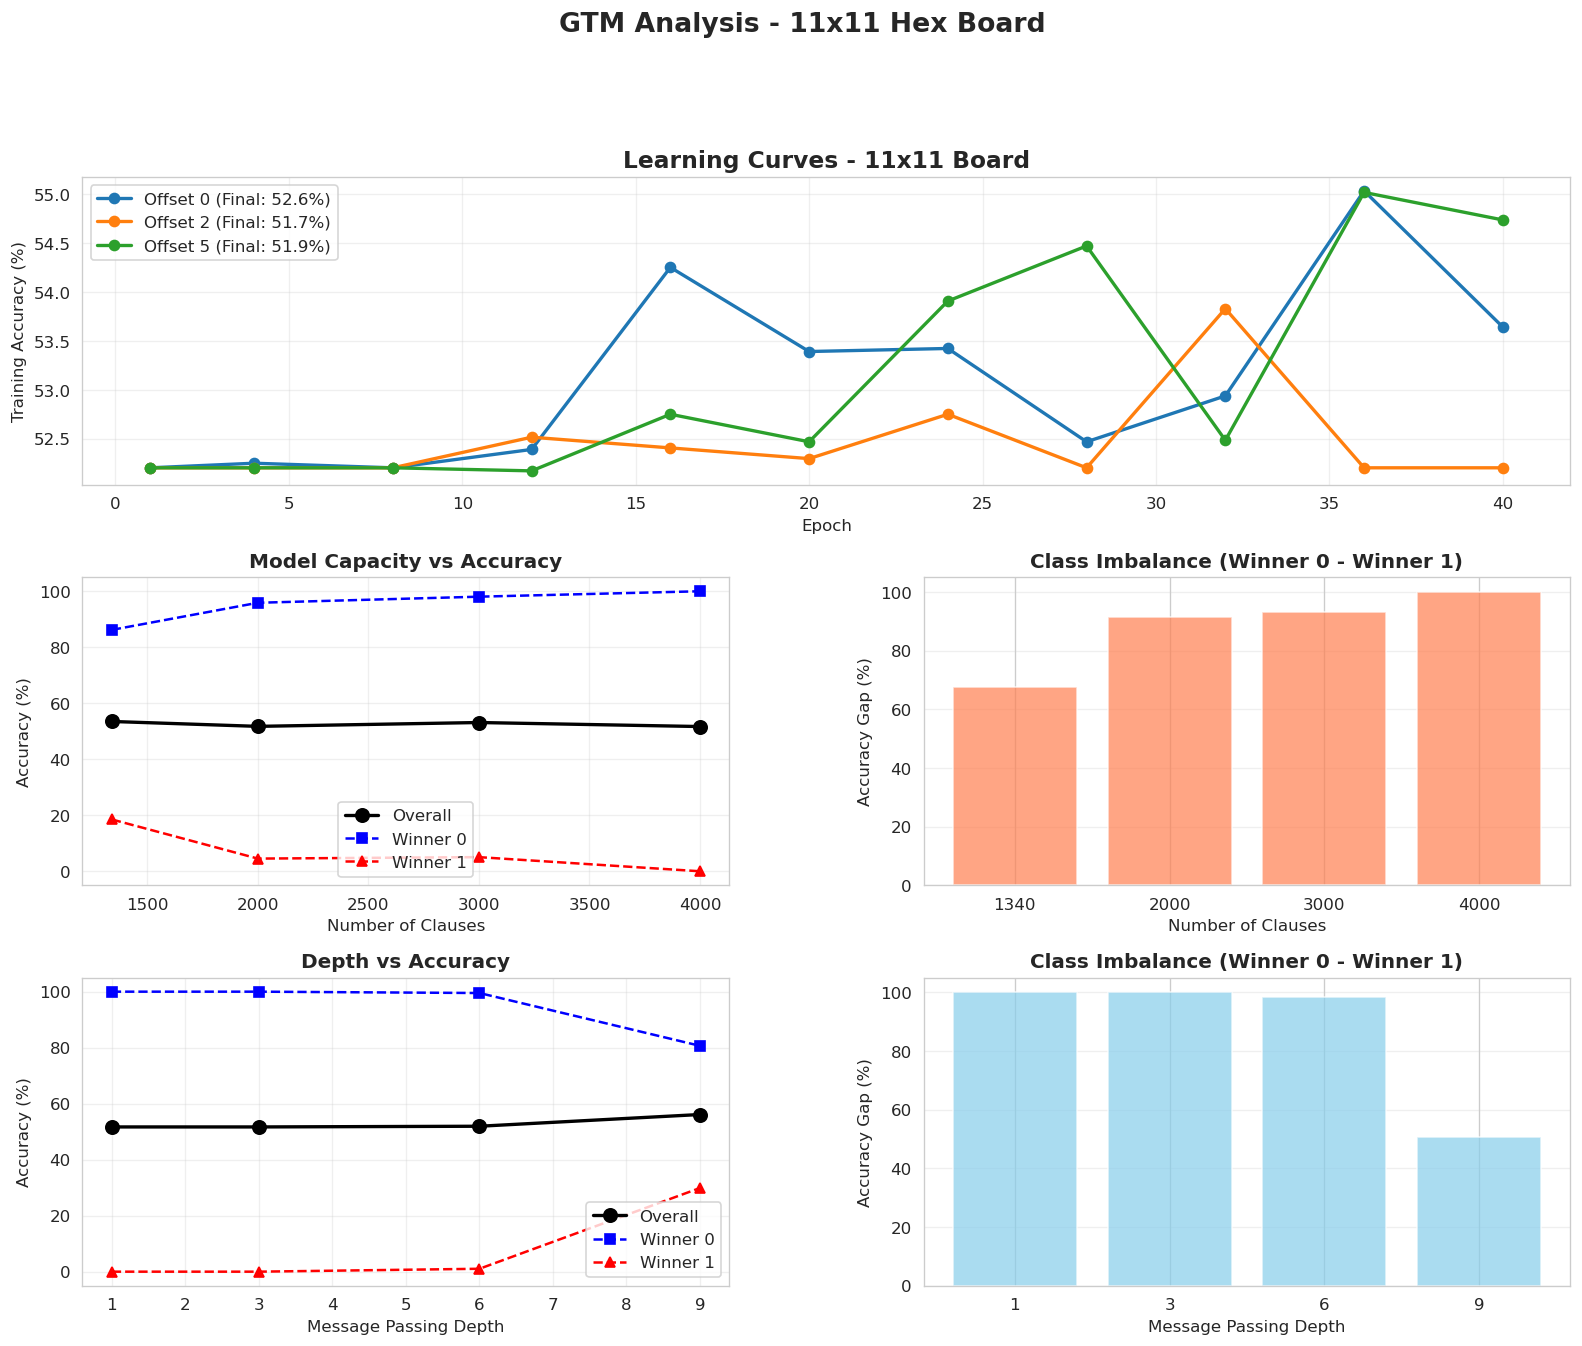


  FINAL SUMMARY - 11x11 Board

CAPACITY EXPERIMENT:
 clauses  overall    winner0   winner1        gap  time_min
    1340  53.5000  86.215236 18.499353  67.715883  4.434391
    2000  51.7500  95.888755  4.527814  91.360941  4.402183
    3000  53.1250  98.065296  5.045278  93.020018  4.997438
    4000  51.6875 100.000000  0.000000 100.000000  5.314531

DEPTH EXPERIMENT:
 depth  overall    winner0   winner1        gap  time_min
     1  51.6875 100.000000  0.000000 100.000000  1.408230
     3  51.6875 100.000000  0.000000 100.000000  4.442441
     6  51.9375  99.516324  1.034929  98.481395  8.921093
     9  56.1250  80.652963 29.883571  50.769392 13.415093

📊 Plot saved: runs/full_analysis_11x11.png



In [126]:
# === COMPREHENSIVE VISUALIZATION ===
if 'results_capacity' in dir() and 'results_depth' in dir():

    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    df_cap = pd.DataFrame(results_capacity)
    df_depth = pd.DataFrame(results_depth)

    # --- ROW 1: Main Experiment Results ---
    if results_main:
        ax1 = fig.add_subplot(gs[0, :])
        for res in results_main:
            epochs, accs = zip(*res['history'])
            ax1.plot(epochs, accs, 'o-', label=f"Offset {res['offset']} (Final: {res['acc']:.1f}%)", linewidth=2)
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Training Accuracy (%)")
        ax1.set_title(f"Learning Curves - {BOARD_DIM}x{BOARD_DIM} Board", fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    # --- ROW 2: Capacity Experiment ---
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(df_cap['clauses'], df_cap['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax2.plot(df_cap['clauses'], df_cap['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax2.plot(df_cap['clauses'], df_cap['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax2.set_xlabel("Number of Clauses")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_title("Model Capacity vs Accuracy", fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.bar(df_cap['clauses'].astype(str), df_cap['gap'], color='coral', alpha=0.7)
    ax3.set_xlabel("Number of Clauses")
    ax3.set_ylabel("Accuracy Gap (%)")
    ax3.set_title("Class Imbalance (Winner 0 - Winner 1)", fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # --- ROW 3: Depth Experiment ---
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(df_depth['depth'], df_depth['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax4.plot(df_depth['depth'], df_depth['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax4.plot(df_depth['depth'], df_depth['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax4.set_xlabel("Message Passing Depth")
    ax4.set_ylabel("Accuracy (%)")
    ax4.set_title("Depth vs Accuracy", fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    ax5 = fig.add_subplot(gs[2, 1])
    ax5.bar(df_depth['depth'].astype(str), df_depth['gap'], color='skyblue', alpha=0.7)
    ax5.set_xlabel("Message Passing Depth")
    ax5.set_ylabel("Accuracy Gap (%)")
    ax5.set_title("Class Imbalance (Winner 0 - Winner 1)", fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')

    plt.suptitle(f"GTM Analysis - {BOARD_DIM}x{BOARD_DIM} Hex Board", fontsize=16, fontweight='bold', y=0.995)

    plot_path = os.path.join(RUNS_DIR, f"full_analysis_{BOARD_DIM}x{BOARD_DIM}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n{'='*70}")
    print(f"  FINAL SUMMARY - {BOARD_DIM}x{BOARD_DIM} Board")
    print(f"{'='*70}\n")

    print("CAPACITY EXPERIMENT:")
    print(df_cap.to_string(index=False))

    print(f"\n{'='*70}")
    print("DEPTH EXPERIMENT:")
    print(df_depth.to_string(index=False))

    print(f"\n{'='*70}")
    print(f"📊 Plot saved: {plot_path}")
    print(f"{'='*70}\n")

In [127]:
# ============================================================
#         GENERATE LATEX TABLE FOR REPORT
# ============================================================

if results_main:
    print("\n" + "="*70)
    print("  LATEX TABLE - Copy this into your report")
    print("="*70 + "\n")

    print("\\begin{table}[htbp]")
    print("\\centering")
    print("\\begin{tabular}{|c|c|c|c|c|c|}")
    print("\\hline")
    print("\\textbf{Offset} & \\textbf{Samples} & \\textbf{Accuracy} & \\textbf{Recall W0} & \\textbf{Recall W1} & \\textbf{F1 (W1)} \\\\")
    print("\\hline")

    for res in results_main:
        offset = res['offset']
        n_samples = len(res['y_test'])
        acc = res['acc']
        recall0 = res['recall0']
        recall1 = res['recall1']
        f1_w1 = res['f1_1']

        if offset == 0:
            label = "0 (End)"
        elif offset == 2:
            label = "2 (End-2)"
        elif offset == 5:
            label = "5 (End-5)"
        else:
            label = str(offset)

        print(f"{label:9s} & {n_samples:4d} & {acc:5.2f}\\% & {recall0:5.2f}\\% & {recall1:5.2f}\\% & {f1_w1:5.2f}\\% \\\\")

    print("\\hline")
    print("\\end{tabular}")
    print("\\caption{Test results for the required offset evaluation on $3\\times3$.}")
    print("\\label{tab:3x3-offset-results}")
    print("\\end{table}")

    print("\n" + "="*70 + "\n")


  LATEX TABLE - Copy this into your report

\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\textbf{Offset} & \textbf{Samples} & \textbf{Accuracy} & \textbf{Recall W0} & \textbf{Recall W1} & \textbf{F1 (W1)} \\
\hline
0 (End)   & 1600 & 52.56\% & 98.67\% &  3.23\% &  6.18\% \\
2 (End-2) & 1600 & 51.69\% & 100.00\% &  0.00\% &  0.00\% \\
5 (End-5) & 1600 & 51.88\% & 93.83\% &  6.99\% & 12.30\% \\
\hline
\end{tabular}
\caption{Test results for the required offset evaluation on $3\times3$.}
\label{tab:3x3-offset-results}
\end{table}




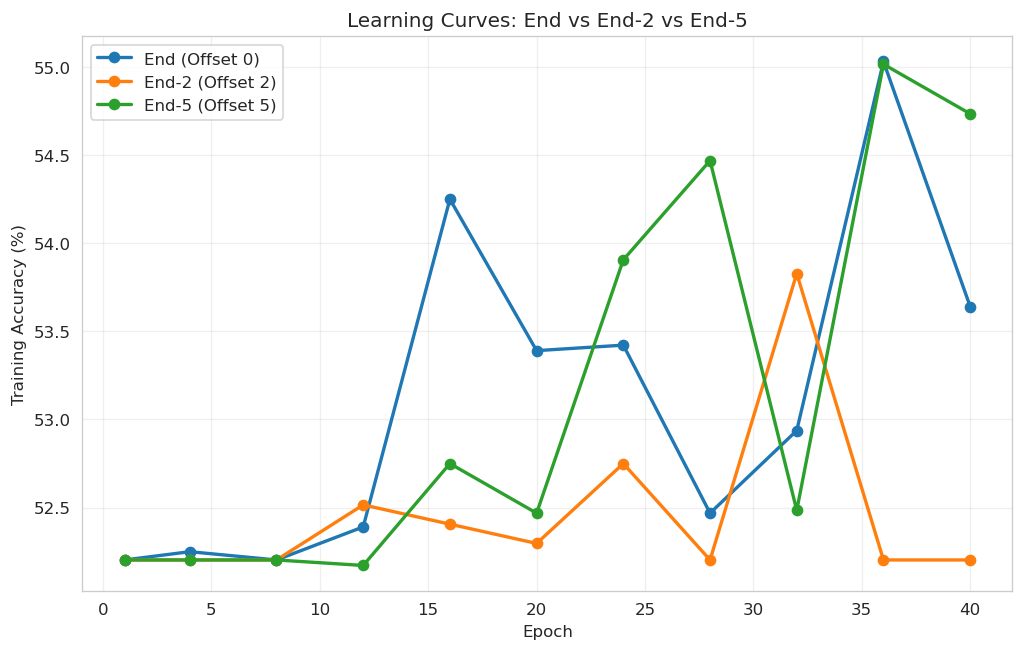

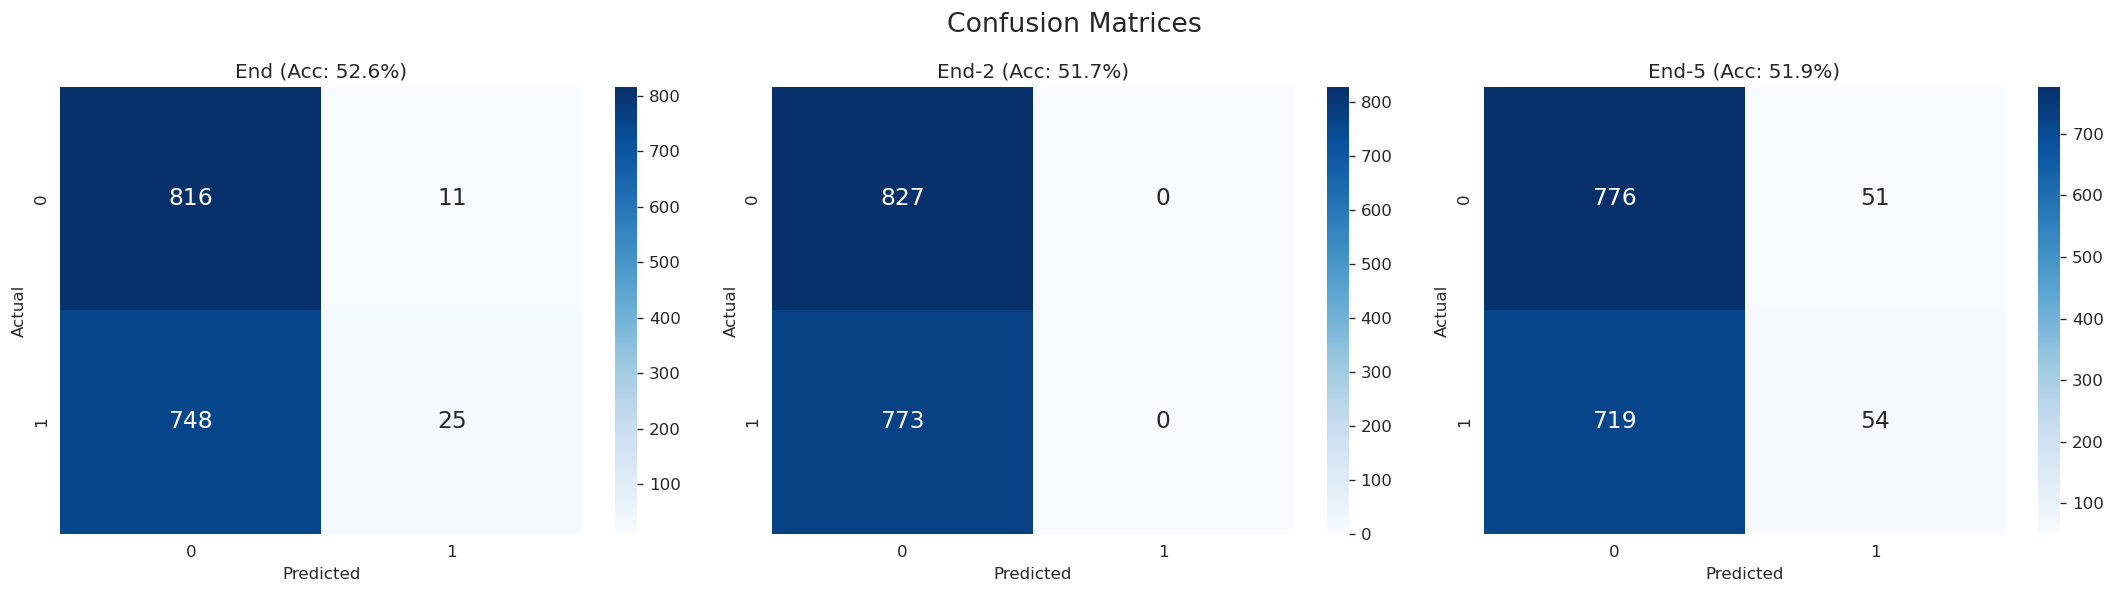

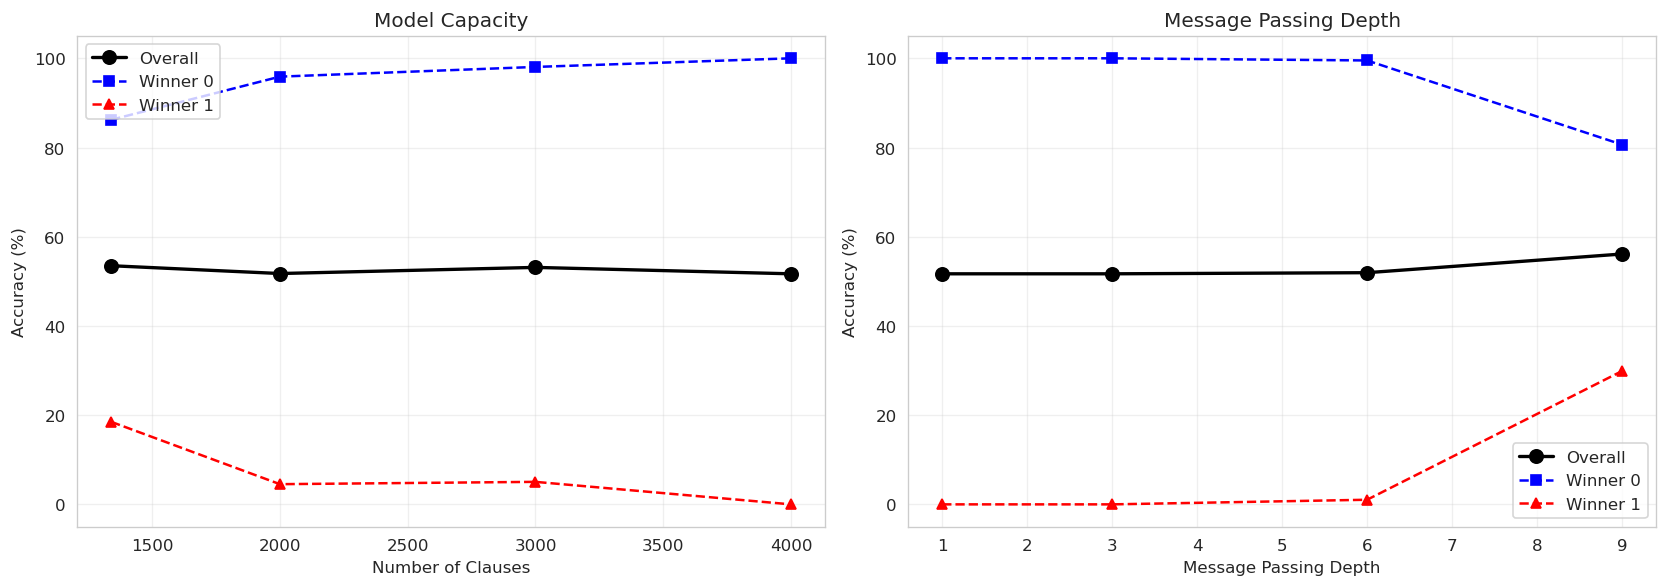

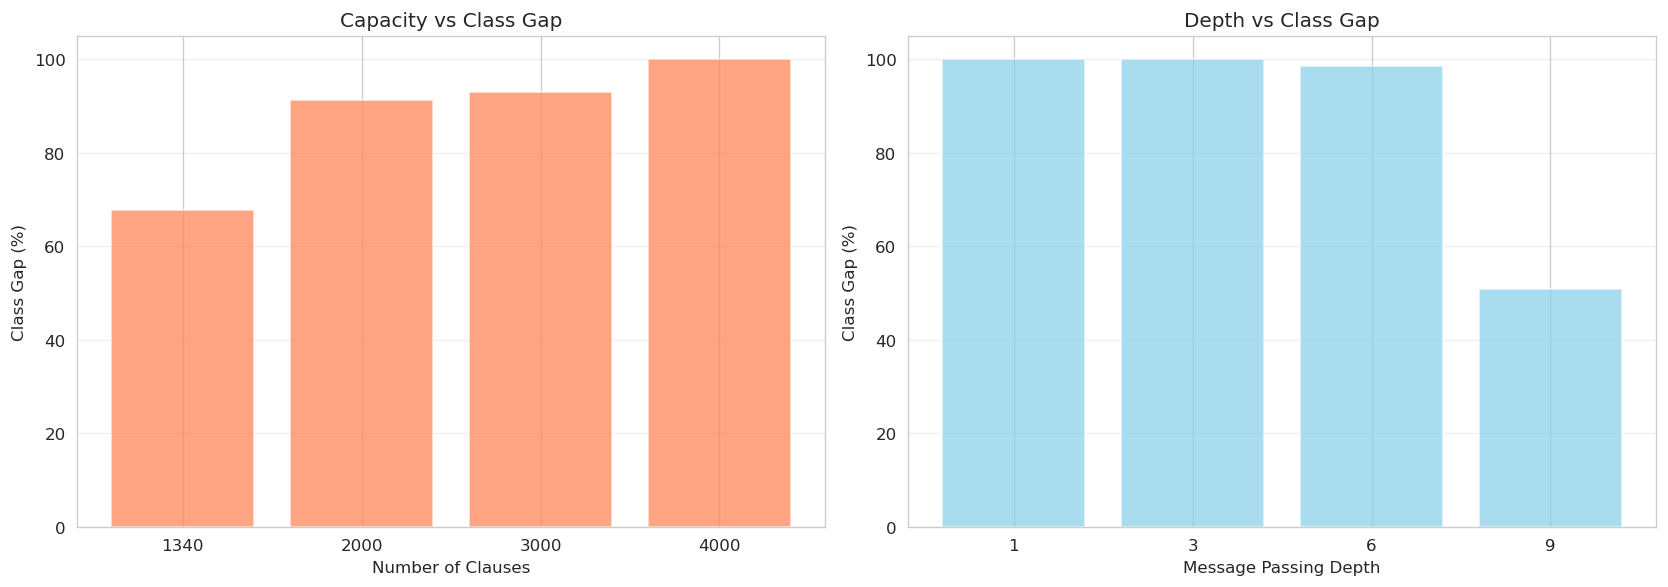


✓ All plots saved to runs/


In [128]:
# === SAVE PLOTS WITH CORRECT NAMES ===
if results_main:
    # Learning curves
    plt.figure(figsize=(10, 6))
    for res in results_main:
        epochs, accs = zip(*res['history']) if isinstance(res['history'][0], tuple) else (range(1, len(res['history'])+1), res['history'])
        label_map = {0: "End (Offset 0)", 2: "End-2 (Offset 2)", 5: "End-5 (Offset 5)"}
        plt.plot(epochs, accs, 'o-', label=label_map.get(res['offset'], f"Offset {res['offset']}"), linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy (%)")
    plt.title("Learning Curves: End vs End-2 vs End-5")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(RUNS_DIR, "11x11_learningcurve.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, res in enumerate(results_main):
        sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[i], annot_kws={'size': 14})
        label_map = {0: "End", 2: "End-2", 5: "End-5"}

        # Fix: Extract label separately to avoid nested f-strings
        label = label_map.get(res['offset'], f"Offset {res['offset']}")
        axes[i].set_title(f"{label} (Acc: {res['acc']:.1f}%)")

        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
    plt.suptitle("Confusion Matrices", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(RUNS_DIR, "11x11_confusionmatrix.png"), dpi=300, bbox_inches='tight')
    plt.show()

# Capacity and Depth plots
if 'results_capacity' in dir() and 'results_depth' in dir():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    df_cap = pd.DataFrame(results_capacity)
    ax1.plot(df_cap['clauses'], df_cap['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax1.plot(df_cap['clauses'], df_cap['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax1.plot(df_cap['clauses'], df_cap['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax1.set_xlabel("Number of Clauses")
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_title("Model Capacity")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    df_depth = pd.DataFrame(results_depth)
    ax2.plot(df_depth['depth'], df_depth['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax2.plot(df_depth['depth'], df_depth['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax2.plot(df_depth['depth'], df_depth['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax2.set_xlabel("Message Passing Depth")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_title("Message Passing Depth")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(RUNS_DIR, "11x11_model_message.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Class gap plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.bar(df_cap['clauses'].astype(str), df_cap['gap'], color='coral', alpha=0.7)
    ax1.set_xlabel("Number of Clauses")
    ax1.set_ylabel("Class Gap (%)")
    ax1.set_title("Capacity vs Class Gap")
    ax1.grid(True, alpha=0.3, axis='y')

    ax2.bar(df_depth['depth'].astype(str), df_depth['gap'], color='skyblue', alpha=0.7)
    ax2.set_xlabel("Message Passing Depth")
    ax2.set_ylabel("Class Gap (%)")
    ax2.set_title("Depth vs Class Gap")
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(os.path.join(RUNS_DIR, "11x11_classgap_capacity_depth.png"), dpi=300, bbox_inches='tight')
    plt.show()

print(f"\n✓ All plots saved to {RUNS_DIR}/")